In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch
import SimpleITK as sitk

import glob
from PIL import Image


In [2]:
import monai

In [9]:
# ONLY IF YOU USE JUPYTER: ADD PATH ⌨️
data_path = "datasets"
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "val", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [3]:
def build_sample_list(data_path, mode="training"):
    
    possible_modes = ["training", "val", "test"]
    
    # test if mode is correct
    if mode not in ["training", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['training', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all .png files in directory, including the path
    paths_xray = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_xray)
    # make a corresponding list for all the mask files
    for xray_path in paths_xray:
        #print(os.path.split(xray_path)[1].split('_')[0])
        image_index = os.path.split(xray_path)[1].split('_')[0]
        suffix = mode
        mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{suffix}_mask.gif')
        manual_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        if os.path.exists(mask_path):
                dicts.append({'img': xray_path, 'mask': mask_path, 'manual':manual_path})
        
    return dicts


class LoadDriveData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        
        image = Image.open(sample['img']).convert('L')# import as grayscale image
        image = np.array(image, dtype=np.uint8)
        
        #print(image.shape)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        mask = np.array(mask, dtype=np.uint8)
        
        manual = Image.open(sample['manual']).convert('L') # import as grayscale image
        manual = np.array(manual, dtype=np.uint8)
        
        #print(manual.shape)
        # mask has value 255 on rib pixels. Convert to binary array
        mask[np.where(mask==255)] = 1
        manual[np.where(manual==255)] =1
        return {'img': image, 'mask': mask, 'manual':manual, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}, 'manual_meta_dict':{'affine':np.eye(2)}}




Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 51.15it/s]


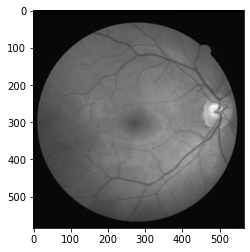

In [4]:
train_dict_list = build_sample_list(data_path,mode='training')
#print(train_dict_list[0])
train_dataset = monai.data.CacheDataset(train_dict_list,transform=LoadDriveData())

#print(train_dataset[0]['manual'])
#plt.hist(train_dataset[0]['mask'].flatten())
plt.imshow(train_dataset[0]['img'],cmap='gray')

#for sample in train_dataset:
   # print(sample['img'].shape)

#plt.hist(train_dataset[0]['mask'].flatten())
#plt.imshow(train_dataset[0]['mask'])

In [6]:
val_dict_list = build_sample_list(data_path,mode='val')
val_dataset = monai.data.CacheDataset(val_dict_list,transform=LoadDriveData())


Loading dataset: 100%|██████████| 4/4 [00:00<00:00, 32.19it/s]


datasets/test/images/16_test.tif
Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...


/Users/sunyiyou/Downloads/DLMI/project_DL/morphology.py:159: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  hes_img = hessian(eq_img)


Using bilateral filter...
Removing noise...
Removing retina's circle...
Image processing done.


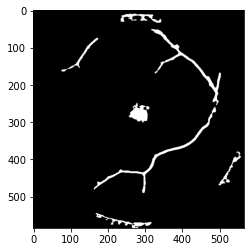

In [7]:
from morphology import detect_veins
print(test_dict_list[0]['img'])
veins = detect_veins(test_dict_list[0]['img'])
plt.imshow(veins, cmap='gray')
plt.show()

Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 59.87it/s]


(1, 512, 512)


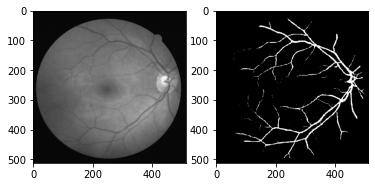

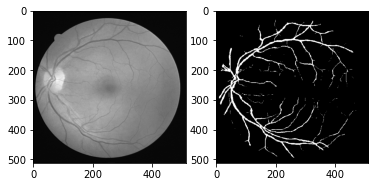

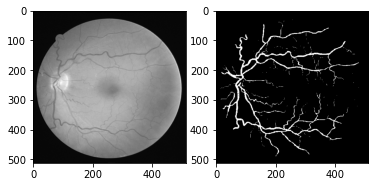

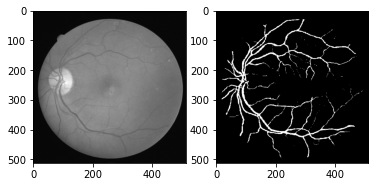

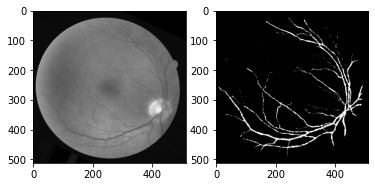

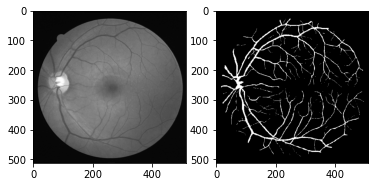

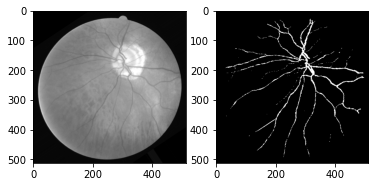

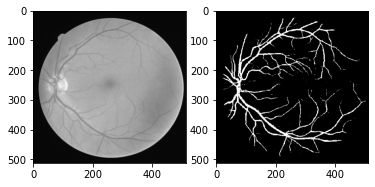

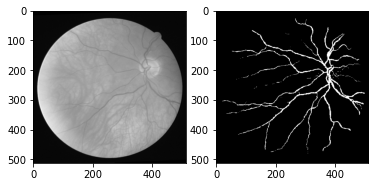

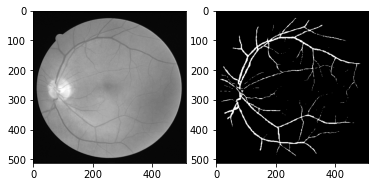

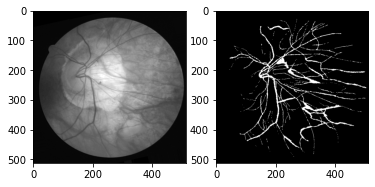

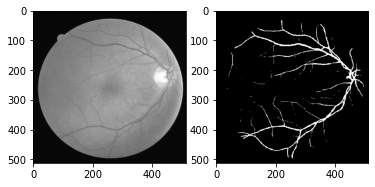

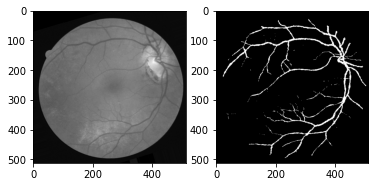

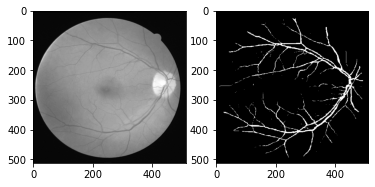

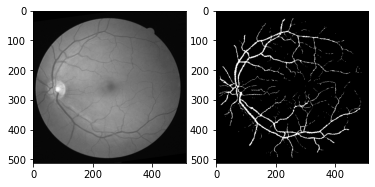

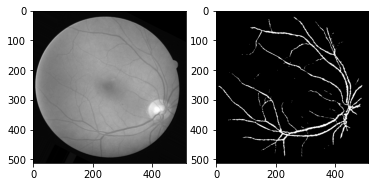

In [7]:
import tensorflow as tf
transforms2 = monai.transforms.Compose(
    [
        
        LoadDriveData(),
       
        monai.transforms.AddChanneld(keys=['img', 'manual']),
        monai.transforms.Resized(
            keys=["img", "manual"],
            mode=( 'bilinear', 'bilinear'),
            align_corners=(True, True),
            spatial_size=(512,512)
        ),
        monai.transforms.ScaleIntensityd(keys=['img','manual'],minv=0, maxv=1),
        monai.transforms.RandFlipd(keys=['img','manual'],prob=0.5,spatial_axis =1),
        monai.transforms.RandSpatialCropd(keys=['img', 'manual'], roi_size=[512,512], random_size=False),
        monai.transforms.RandRotated(keys=['img','manual'], range_x = np.pi/4,prob=0.5,mode=['bilinear', 'nearest'])                                
    ])

train_dataset2 = monai.data.CacheDataset(build_sample_list(data_path, mode="training"), transform=transforms2)
print(train_dataset2[0]['manual'].shape)

for sample in train_dataset2:
    #print(sample['img'].shape)
    plt.figure()
    plt.subplot(1,2,1)
    img = np.squeeze(sample['img'])
    
    plt.imshow(img,cmap='gray')
    manual = np.squeeze(sample['manual'])
    plt.subplot(1,2,2)
    plt.imshow(manual,cmap='gray')



In [8]:
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """
    
    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")
    
    pre_compose_list = list()
    
    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        

In [5]:
train_loader = monai.data.DataLoader(train_dataset2, batch_size=16, shuffle=True)
print(train_dataset2[0]['img'].shape)
print(len(train_loader))
val_dataset = monai.data.CacheDataset(build_sample_list(data_path, mode="val"), transform=transforms2)
validation_loader = monai.data.DataLoader(val_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels = (8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=0,
).to(device)
#print(model)
loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The used device is cpu


In [9]:
def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'drive'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['manual'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
    
# TO BE REMOVED

In [ ]:
from tqdm.notebook import tqdm
import wandb

run = wandb.init(
    project='u-net',
    name='test',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'transform': from_compose_to_list(transforms2),
        'batch_size': train_loader.batch_size,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics


for epoch in tqdm(range(500)):
    model.train()    
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: 
        #print(batch_data['img'].shape)
        step += 1
        optimizer.zero_grad()
        outputs = model(batch_data["img"].float().to(device))
        loss = loss_function(outputs, batch_data["manual"].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss = epoch_loss/step
    # validation part
    step = 0
    val_loss = 0
    for batch_data in validation_loader:
        step += 1
        model.eval()
        outputs = model(batch_data['img'].float().to(device))
        loss = loss_function(outputs, batch_data['manual'].to(device))
        val_loss+= loss.item()
    val_loss = val_loss / step
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)

# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

In [64]:
torch.save(model, 'unet.pt')
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'unetentire.pth')

In [6]:

model = torch.load('unet.pt')
#model.eval()
#print(model)

In [7]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection the result of one sample by plotting 
    the X-ray image, the ground truth (green) and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[256,256])
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)
    Sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu())).squeeze()
    
    fig, ax = plt.subplots(1,2, figsize = [12, 10])
    
    # Plot X-ray image
    ax[0].imshow(sample["img"].squeeze(), 'gray')
    # Plot ground truth
    mask = np.squeeze(sample['manual'])
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    #cv2.imwrite(f'results_drive/1st_manual/{image_index}_test.png',overlay_mask)
    ax[0].imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    ax[0].set_title('Ground truth')
    # Plot output
    overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
    #cv2.imwrite(f'results_drive/prediction/{image_index}_test.png',overlay_output)
    ax[1].imshow(sample['img'].squeeze(), 'gray')
    ax[1].imshow(overlay_output, 'Reds', alpha = 0.7, clim=[0,1])
    ax[1].set_title('Prediction')
    plt.show()

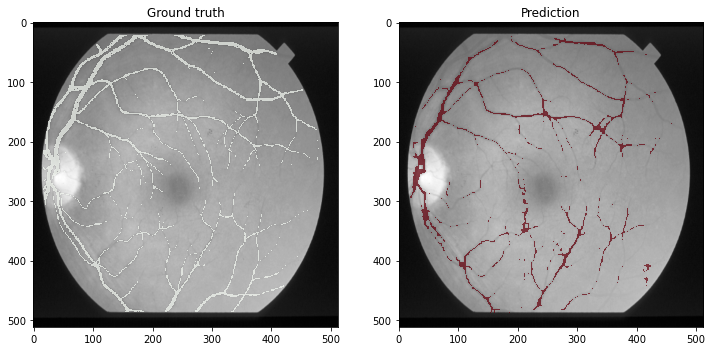

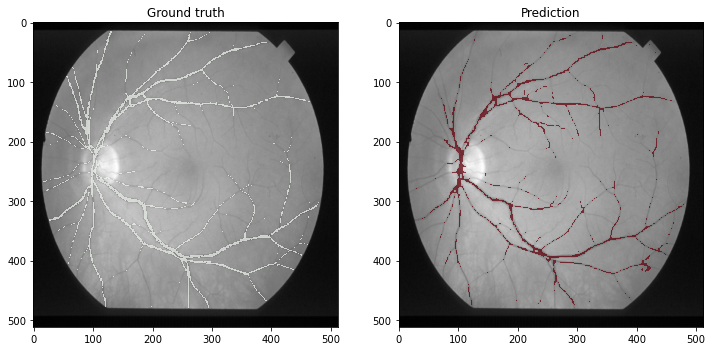

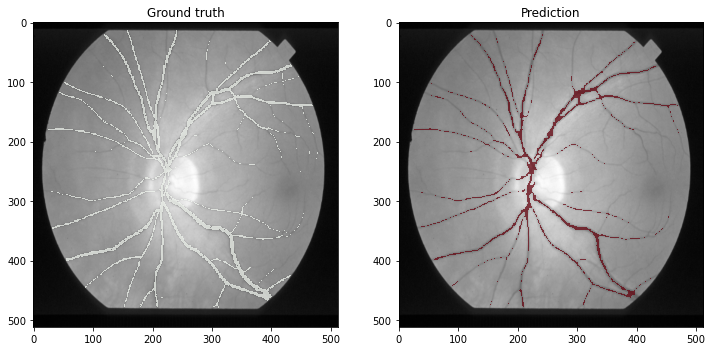

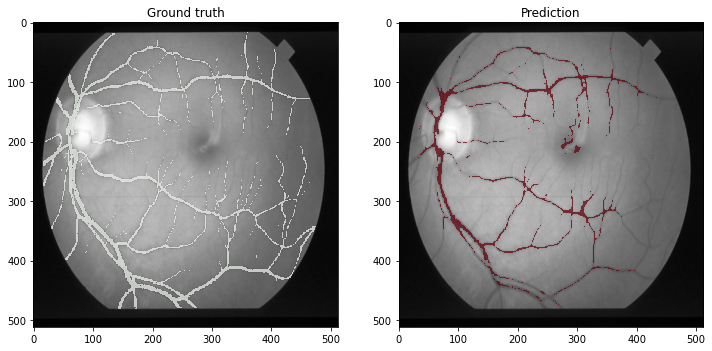

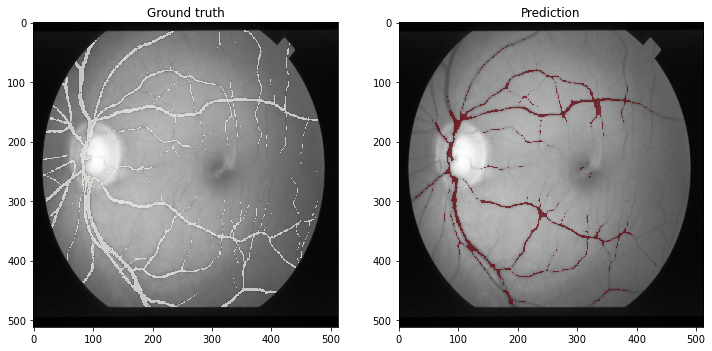

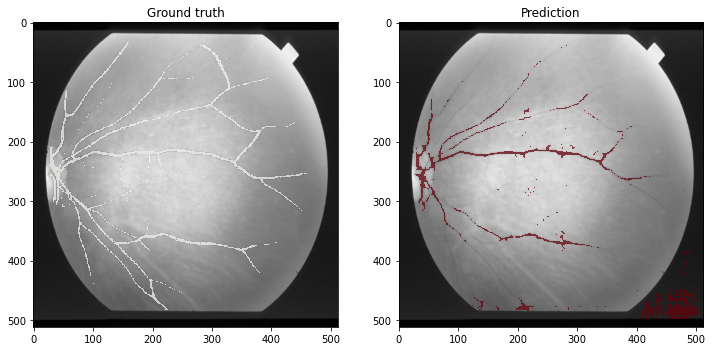

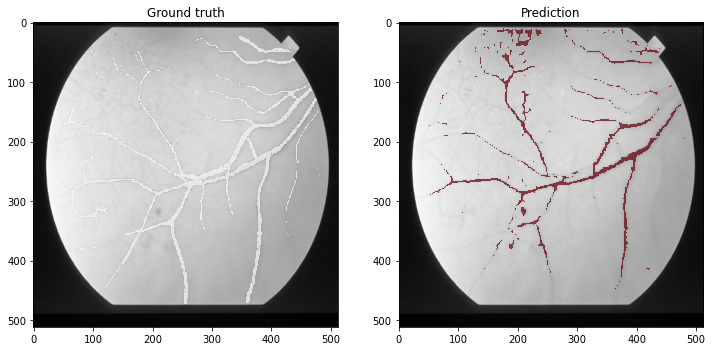

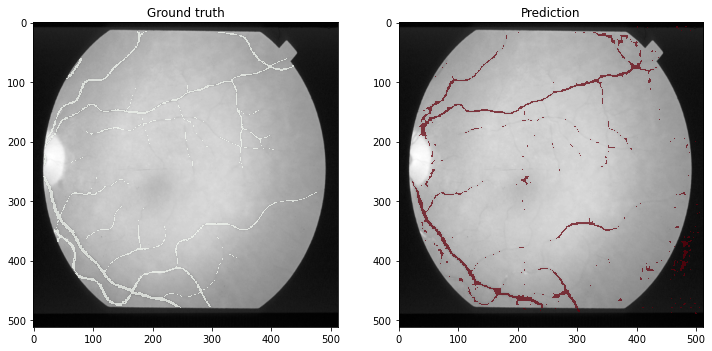

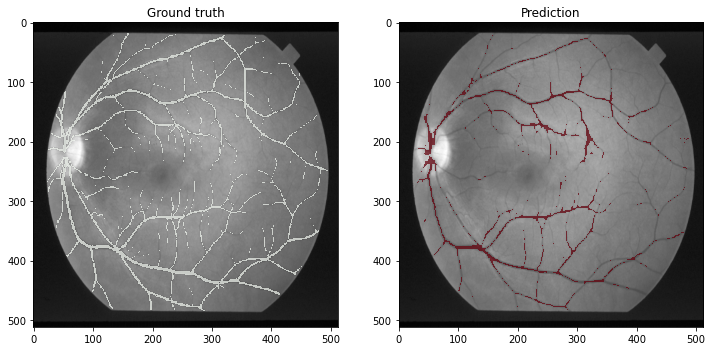

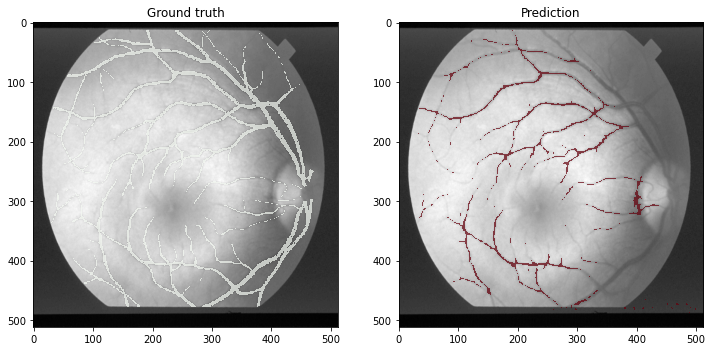

In [43]:

for sample in test_loader:       
    #ax[1][2].imshow(sample['img'].squeeze(), 'gray')
   
    visual_evaluation(sample,model)
    

In [11]:
print(test_set[0]['manual'])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


Loading dataset: 100%|██████████| 20/20 [00:01<00:00, 18.10it/s]
<ipython-input-15-6acb063a04f5>:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-15-6acb063a04f5>:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


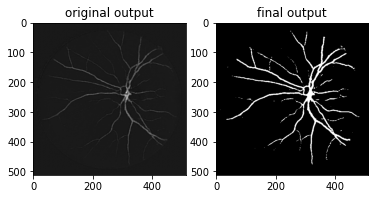

In [15]:
'''
This block is use to load the test data from DRIVE and predict the results of the model

'''
test_dict_list = build_sample_list(data_path,mode='test')
#print(test_dict_list)
test_transforms = monai.transforms.Compose(
    [
        
        LoadDriveData(),
       
        monai.transforms.AddChanneld(keys=['img', 'manual']),
        monai.transforms.Resized(
            keys=["img", "manual"],
            mode=( 'bilinear', 'bilinear'),
            align_corners=(True, True),
            spatial_size=(512,512)
        ),
        monai.transforms.ScaleIntensityd(keys=['img','manual'],minv=0, maxv=255),                             
    ])
#print(test_dict_list)
test_set = monai.data.CacheDataset(test_dict_list, transform=test_transforms)
#plt.imshow(test_set[1]['img'].squeeze(),cmap = 'gray')
test_loader = monai.data.DataLoader(test_set, batch_size=1)

for (sample, test_dict) in zip(test_loader, test_dict_list) :
    #print(os.path.split(test_dict['img'])[1].split('_')[0])
    #image_index = os.path.split(xray_path)[1].split('_')[0]
    image_index = os.path.split(test_dict['img'])[1].split('_')[0]
    model.eval()
    #print(image_index)
    outputs = model(sample['img'].float().to(device))
    outputs = outputs.detach().numpy().squeeze().squeeze()
    output = np.zeros(outputs.shape)
    plt.subplot(1,2,1)
    plt.imshow(outputs,cmap='gray')
    # originial output without data post processing
    plt.title('original output')
    
    #print(np.where(outputs>0.99 | outputs<0.1))
    output[np.where( outputs>0.99 )]= 255
    
    plt.subplot(1,2,2)
    plt.imshow(output,cmap='gray')
    plt.title('final output')
    
    #plt.imshow(outputs.detach().numpy().squeeze(), cmap='gray')
    #print(sample['manual'].numpy().squeeze().shape)
    cv2.imwrite(f'results_drive/1st_manual/{image_index}_test.png',sample['manual'].numpy().squeeze())
    cv2.imwrite(f'results_drive/prediction/{image_index}_test.png',output)
    #print(outputs.detach().numpy().squeeze().squeeze().shape)
        

In [16]:
'''
This block is for to transform the mask data for comparision of DRIVE
'''
test_transforms2 = monai.transforms.Compose(
    [
        
        LoadDriveData(),
       
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.Resized(
            keys=["img", "mask"],
            mode=( 'bilinear', 'bilinear'),
            align_corners=(True, True),
            spatial_size=(512,512)
        ),
        monai.transforms.ScaleIntensityd(keys=['img','mask'],minv=0, maxv=255),                             
    ])
test_set2 = monai.data.CacheDataset(test_dict_list, transform=test_transforms2)
for (sample, test_dict) in zip(test_set2, test_dict_list):
    image_index = os.path.split(test_dict['img'])[1].split('_')[0]
    cv2.imwrite(f'results_drive/mask/{image_index}_test_mask.png',sample['mask'].squeeze())

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 37.98it/s]


In [ ]:
plt.imshow(output, cmap='gray')
print(output)

Loading dataset: 100%|██████████| 10/10 [00:00<00:00, 19.66it/s]


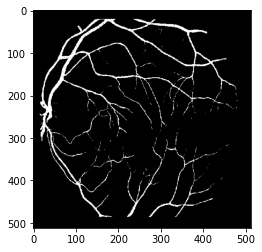

<Figure size 432x288 with 0 Axes>

In [17]:
'''
This block is for read the STARE data and predict by u-net
'''
def build_stare_list(data_path, mode="training"):
    
    possible_modes = ["training", "val", "test"]
    
    # test if mode is correct
    if mode not in ["training", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['training', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all .png files in directory, including the path
    paths_xray = glob.glob(os.path.join(data_path, mode, 'images', '*.ppm'))
    #print(paths_xray)
    # make a corresponding list for all the mask files
    for xray_path in paths_xray:
        #print(os.path.split(xray_path)[1].split('.')[0])
        image_index = os.path.split(xray_path)[1].split('.')[0]
        #print(image_index)
        suffix = mode
        mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}.ppm')
        manual_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}.ah.ppm')
        if os.path.exists(mask_path):
                dicts.append({'img': xray_path, 'mask': mask_path, 'manual':manual_path})
        
    return dicts
data_path2 = 'STARE'
test_dict_list = build_stare_list(data_path2,mode = "test")
#print(test_dict_list )
test_transforms = monai.transforms.Compose(
    [
        
        LoadDriveData(),
       
        monai.transforms.AddChanneld(keys=['img', 'manual']),
        monai.transforms.Resized(
            keys=["img", "manual"],
            mode=( 'bilinear', 'bilinear'),
            align_corners=(True, True),
            spatial_size=(512,512)
        ),
        monai.transforms.ScaleIntensityd(keys=['img','manual'],minv=0, maxv=255),                             
    ])
#print(test_dict_list)
test_set = monai.data.CacheDataset(test_dict_list, transform=test_transforms)
plt.imshow(test_set[0]['manual'].squeeze(),cmap = 'gray')
plt.figure()
#plt.imshow(test_set[0]['img'].squeeze(),cmap = 'gray')

test_loader = monai.data.DataLoader(test_set, batch_size=1)

Loading dataset: 100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


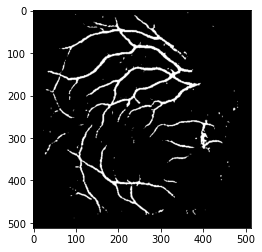

In [22]:
for (sample, test_dict) in zip(test_loader, test_dict_list) :
    #print(os.path.split(test_dict['img'])[1].split('_')[0])
    #image_index = os.path.split(xray_path)[1].split('_')[0]
    image_index = os.path.split(test_dict['img'])[1].split('.')[0]
    model.eval()
    outputs = model(sample['img'].float().to(device))
    outputs = outputs.detach().numpy().squeeze().squeeze()
    
    
    output = np.zeros(outputs.shape)
    output[np.where( outputs>0.98 )]= 255
    
    #plt.figure()
    #plt.imshow(sample['manual'].float().numpy().squeeze(),cmap='gray')
    plt.imshow(output,cmap='gray')
    
    cv2.imwrite(f'results_STARE/1st_manual/{image_index}.png',sample['manual'].float().numpy().squeeze().squeeze())
    #cv2.imwrite(f'results_STARE/1st_manual/{image_index}.png',sample['manual'].float().numpy().squeeze().squeeze())
    cv2.imwrite(f'results_STARE/prediction/{image_index}.png',output)
#plt.hist(output)

Loading dataset: 100%|██████████| 10/10 [00:00<00:00, 80.73it/s]


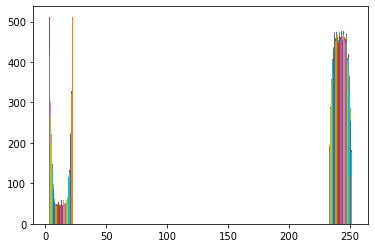

In [23]:
test_transforms = monai.transforms.Compose(
    [
        
        LoadDriveData(),
       
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.Resized(
            keys=["img", "mask"],
            mode=( 'bilinear', 'bilinear'),
            align_corners=(True, True),
            spatial_size=(512,512)
        ),
        monai.transforms.ScaleIntensityd(keys=['img','mask'],minv=0, maxv=255),                             
    ])
#print(test_dict_list)
test_set = monai.data.CacheDataset(test_dict_list, transform=test_transforms)
for (sample, test_dict) in zip(test_set, test_dict_list) :
    image_index = os.path.split(test_dict['img'])[1].split('.')[0]
    
    #sample['mask'][np.where(sample['mask']==1)] = 255
    #plt.imshow(sample['manual'].squeeze(),cmap='gray')
    plt.hist(sample['mask'].squeeze())
    
    cv2.imwrite(f'results_STARE/mask/{image_index}.png',sample['mask'].squeeze())
    

In [ ]:
'''
This block is for read and transform the STARE data to make them fits the size of GAN
The input for GAN should be 512*512*3
'''

class LoadSTAREData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        
        image = Image.open(sample['img'])
        b, g, r = image.split()
        image = Image.merge("RGB", (r, g, b))
        image = np.array(image, dtype=np.uint8)
        
        #print(image.shape)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        mask = np.array(mask, dtype=np.uint8)
        
        manual = Image.open(sample['manual']).convert('L') # import as grayscale image
        manual = np.array(manual, dtype=np.uint8)
        
        #print(manual.shape)
        # mask has value 255 on rib pixels. Convert to binary array
        mask[np.where(mask==255)] = 1
        manual[np.where(manual==255)] =1
        return {'img': image, 'mask': mask, 'manual':manual, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}, 'manual_meta_dict':{'affine':np.eye(2)}}

test_transforms3 = monai.transforms.Compose(
    [
        
        LoadSTAREData(),
        monai.transforms.AddChanneld(keys=['img']),
       
        
        monai.transforms.Resized(
            keys=['img','mask'],
            mode=('trilinear'),
            align_corners=(True),
            spatial_size=(512,512,3)
        ),
        #monai.transforms.ScaleIntensity(keys=['img'],minv=0, maxv=255), 
       
    ])

data_path2 = 'STARE'
test_dict_list = build_stare_list(data_path2,mode = "test")

    
test_set3 = monai.data.CacheDataset(test_dict_list, transform= test_transforms3)
print(test_set3[0]['img'].shape)

for (sample, test_dict) in zip(test_set3, test_dict_list):
    image_index = os.path.split(test_dict['img'])[1].split('.')[0]
    #cv2.imwrite(f'results_STARE/mask/{image_index}.png',sample['mask'].squeeze())
    cv2.imwrite(f'results_STARE/images/{image_index}.png',sample['img'].squeeze())
